In [2]:
import matplotlib.pyplot as plt
import torch

from src.data_modules.segmentation_data_module import CbisDdsmDataModuleSegmentation
from src.models.segmentation_model import SegmentationModel

/home/kristof/VITMMB10/mammo-vision/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datamodule = CbisDdsmDataModuleSegmentation(
    root_dir="data/cbis-ddsm-segme",
    tumor_type="mass",
    batch_size=1,
    num_workers=4,
)

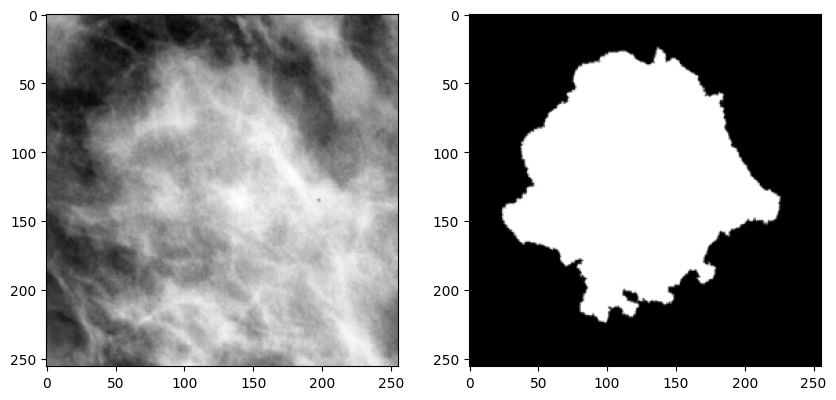

In [4]:
for batch in datamodule.train_dataloader():
    x, y = batch[0][0], batch[1][0]

    image = x.squeeze().numpy()
    mask = y.squeeze().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap="gray")
    axes[1].imshow(mask[1], cmap="gray")

    plt.show()
    break

In [5]:
model = SegmentationModel(weight_path="models/mass-segmentation.ckpt")

Loaded weights from models/mass-segmentation.ckpt


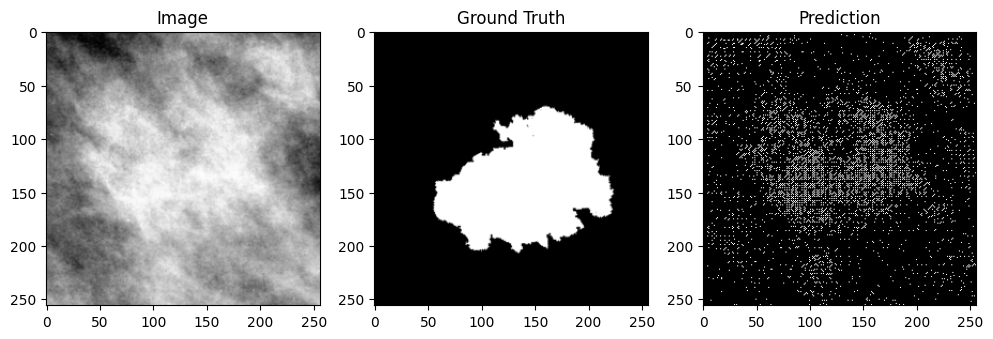

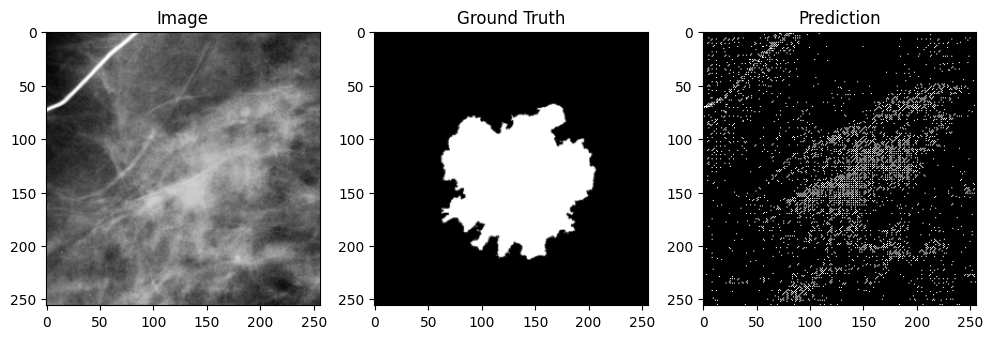

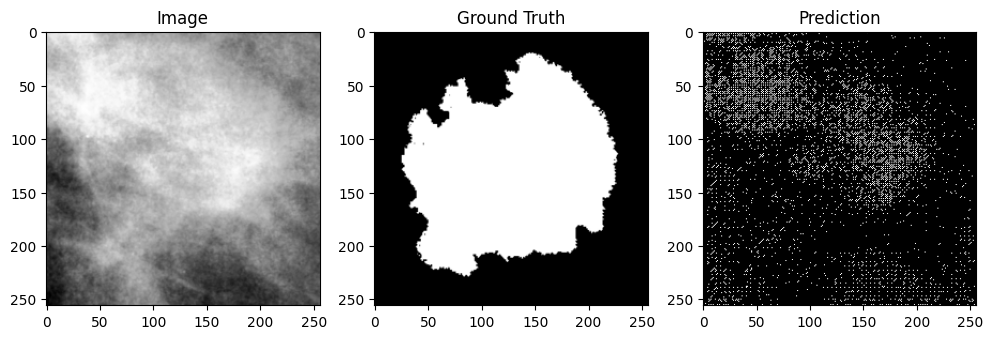

In [18]:
model.eval()

for idx, batch in enumerate(datamodule.test_dataloader()):
    if idx % 5 != 0:
        continue

    x, y = batch

    # Get model predictions
    with torch.no_grad():
        prediction = torch.softmax(model(x.to(model.device)), dim=1)
        prediction = torch.squeeze((prediction > 0.7).int())[0]
        prediction = torch.squeeze(prediction).numpy()

    # Plot results
    image = torch.squeeze(x).numpy()
    mask = torch.squeeze(y).numpy()
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Image")
    axes[1].imshow(mask[1], cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Prediction")
    plt.show()

    if idx == 10:
        break